## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample 
import scipy
import tensorflow as tf

import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [7]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
5506,00001473_006.png,Cardiomegaly|Pleural_Thickening,6,1473,64,M,PA,2670,2661,0.143,0.143,NaN,/data/images_002/images/00001473_006.png
68619,00016939_000.png,No Finding,0,16939,47,M,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00016939_000.png
80736,00019835_000.png,No Finding,0,19835,62,M,PA,2992,2991,0.143,0.143,NaN,/data/images_009/images/00019835_000.png


In [9]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
72055,00017747_016.png,Nodule,16,17747,33,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
73775,00018143_005.png,No Finding,5,18143,38,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3675,00001005_001.png,No Finding,1,1005,30,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: 'True' if x==1.0 else 'False')

## Create your training and testing data:

In [11]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_df, valid_df = skl.train_test_split(vargs, 
                                   test_size = 0.2, 
                                   stratify = vargs['Pneumonia'])
    
    # Condition 1: To have EQUAL amount of positive and negative cases of Pneumonia in Training
    p_inds = train_df[train_df.Pneumonia==1].index.tolist()
    np_inds = train_df[train_df.Pneumonia==0].index.tolist()
    np_sample = sample(np_inds,len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]
    
    # Condition 2: To have positive cases (1:4 as expected in REAL clinical situation) of Pneumonia in Validation
    p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
    np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()
    np_sample = sample(np_inds, 4*len(p_inds))
    valid_df = valid_df.loc[p_inds + np_sample]
    
    # Demographic information, image view positions should be handled by random.sample

    return train_df, valid_df

In [12]:
train_df, valid_df = create_splits(all_xray_df)
# Condition 1: Should reflect (1:1) for balance
print('train_df Pneumonia#:' + str(train_df['Pneumonia'].sum()/len(train_df)))
# Condition 2: Should reflect REAL clinical situation (1:4)
print('valid_df Pneumonia#:' + str(valid_df['Pneumonia'].sum()/len(valid_df)))

train_df Pneumonia#:0.5
valid_df Pneumonia#:0.2


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [13]:
IMG_SIZE = (224, 224)
S_BATCH_SIZE = 128 # small
B_BATCH_SIZE = 256 # big

In [14]:
def my_image_augmentation(*vargs):
        
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # vertical_flip should be FALSE!
    if (vargs[0] == 'train'): 
        idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.01, 
                              width_shift_range=0.01, 
                              rotation_range=1, 
                              shear_range = 0.05,
                              zoom_range=0.01)
    else: # validation
        idg = ImageDataGenerator(rescale=1. / 255.0)
    
    
    return idg


def make_train_gen(*vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = vargs[0].flow_from_dataframe(dataframe=vargs[1], 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = vargs[2])
     

    return train_gen


def make_val_gen(*vargs):
    
    val_gen = vargs[0].flow_from_dataframe(dataframe = vargs[1], 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = vargs[2],
                                             shuffle=False) 
    
    return val_gen

In [15]:
## May want to pull a single large batch of random validation data for testing after each epoch:
# Note that the validation data should not be augmented! Only do some basic intensity rescaling
val_idg = my_image_augmentation('validation')
val_gen = make_val_gen(val_idg, valid_df, B_BATCH_SIZE)
                       
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


In [16]:
train_idg = my_image_augmentation('train')
train_gen = make_train_gen(train_idg, train_df, S_BATCH_SIZE)

Found 2290 validated image filenames belonging to 2 classes.


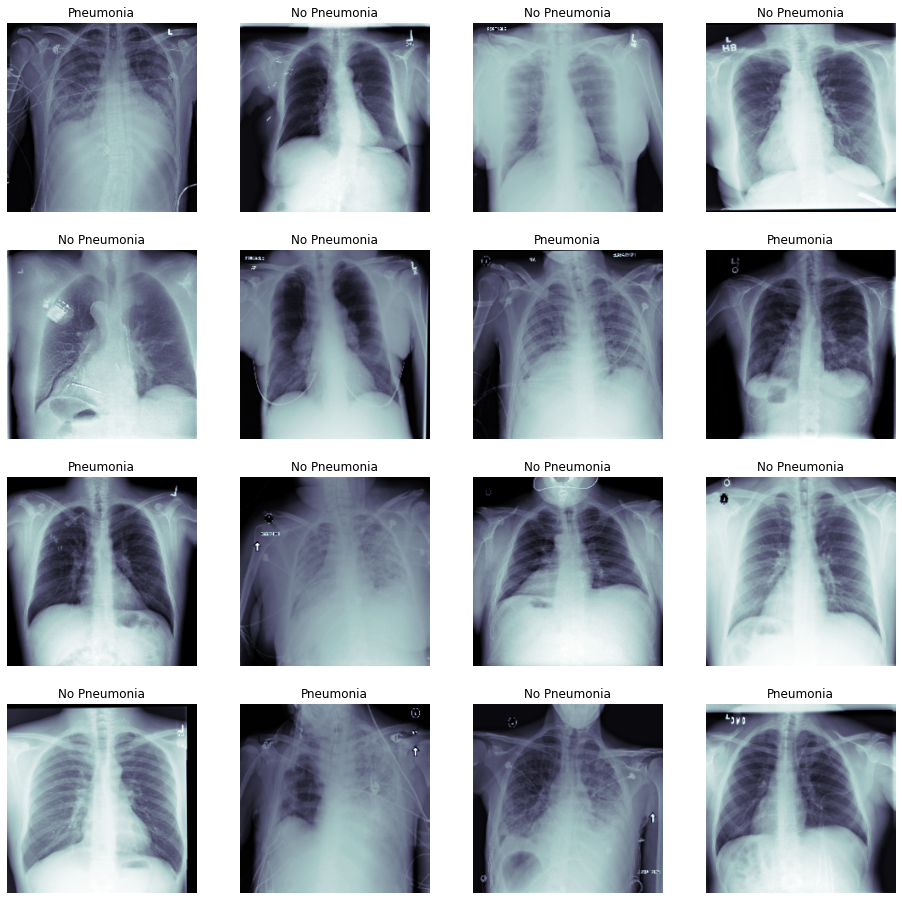

In [17]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [18]:
def load_pretrained_model():  
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model

In [19]:
def build_my_model(*vargs):
    
    vgg_model = vargs[0]
    
    ##  Freeze all but the last convolutional layer of VGG16
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
   
    #for layer in vgg_model.layers:
    #    print(layer.name, layer.trainable)

    # Build our own model
    new_model = Sequential()

    # Add the convolutional part of the VGG16 model from above
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a convolutional layer.
    new_model.add(Flatten())

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    new_model.add(Dense(1, activation='sigmoid'))
    
    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']

    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return new_model


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [20]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

def decay(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

# lr_scheduler = LearningRateScheduler(decay, verbose=1)

callbacks_list = [checkpoint, early]

### Start training! 

In [21]:
## train your model
vgg_model = load_pretrained_model()
my_model = build_my_model(vgg_model)
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 20, 
                          callbacks = callbacks_list)

553467904/553467096 [==============================] - 7s 0us/step
Epoch 1/20
18/18 [==============================] - 76s 4s/step - loss: 0.7792 - binary_accuracy: 0.5118 - val_loss: 0.9059 - val_binary_accuracy: 0.0039

Epoch 00001: val_loss improved from inf to 0.90585, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
18/18 [==============================] - 61s 3s/step - loss: 0.7419 - binary_accuracy: 0.5223 - val_loss: 0.9215 - val_binary_accuracy: 0.0078

Epoch 00002: val_loss did not improve from 0.90585
Epoch 3/20
18/18 [==============================] - 62s 3s/step - loss: 0.7007 - binary_accuracy: 0.5476 - val_loss: 0.7751 - val_binary_accuracy: 0.3203

Epoch 00003: val_loss improved from 0.90585 to 0.77507, saving model to xray_class_my_model.best.hdf5
Epoch 4/20
18/18 [==============================] - 62s 3s/step - loss: 0.6867 - binary_accuracy: 0.5611 - val_loss: 0.8031 - val_binary_accuracy: 0.3008

Epoch 00004: val_loss did not improve from 0.77507
Epoch 5/20


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [22]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, verbose = True)
#pred_Y = my_model.predict_generator(val_gen, batch_size = 32, verbose = True)

256/256 [==============================] - 7s 26ms/step


In [23]:
# AUC area under ROC: aggregate measure of performance across all possible classification thresholds 
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

# Precision = Positive Predictive Value (High precision gives us more confidence in a positive result)
# Recall = True Positive Rate (High recall gives us more confidence in a negative result)
# Depending on our usecase, we can maximize precision or recall
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

# F1 score: Harmonic mean, evaluates test accuracy when there are class imbalances
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    
# Plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all epochs
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:88: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


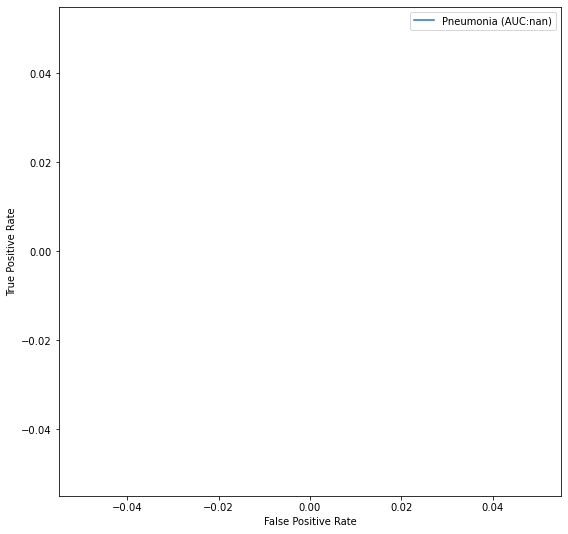

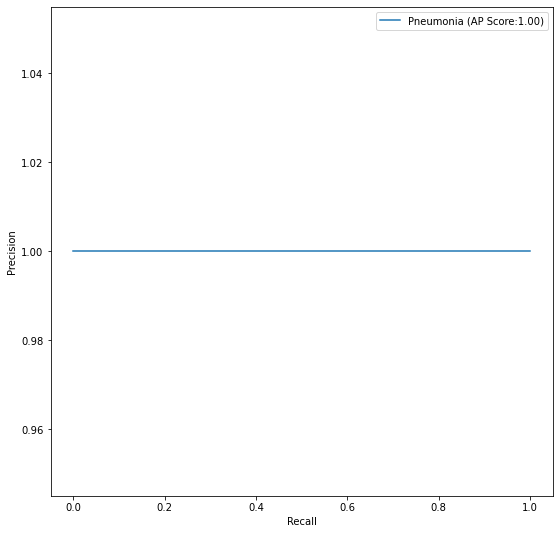

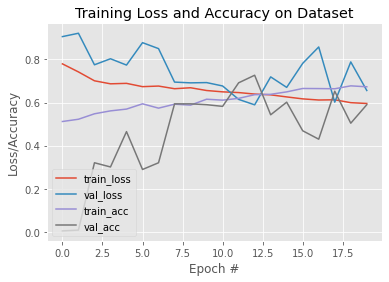

In [24]:
## plot figures
plot_auc(valY, pred_Y)
plot_precision_recall_curve(valY, pred_Y)
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [37]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Accuracy: it is not a great measure for imbalanced dataset as in our case
# I'd like to maximize precision given that this model will be used to confirm a diagnosis (to assist a radiologist)
# So I'd like to have more confidence in a positive result

# Look at the threshold where precision is 0.7
precision_value = 0.7
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))


Precision is: 0.6666666666666666
Recall is: 0.1111111111111111
Threshold is: 0.60196507
F1 Score is: 0.1904761904761905


In [38]:
def plot_f1s(valY, pred_Y):
    precision, recall, thresholds = precision_recall_curve(valY.astype(int), pred_Y)
    f1_scores = []
    for i in thresholds:
        fig, c_ax = plt.subplots(1,1, figsize = (10, 10))
        c_ax.plot(thresholds, f1_scores, label = 'F1-Score vs. Threshold')
        c_ax.legend()
        c_ax.set_xlabel('Threshold')
        c_ax.set_ylabel('F1-Score')
    f1_scores    

ValueError: x and y must have same first dimension, but have shapes (59,) and (0,)

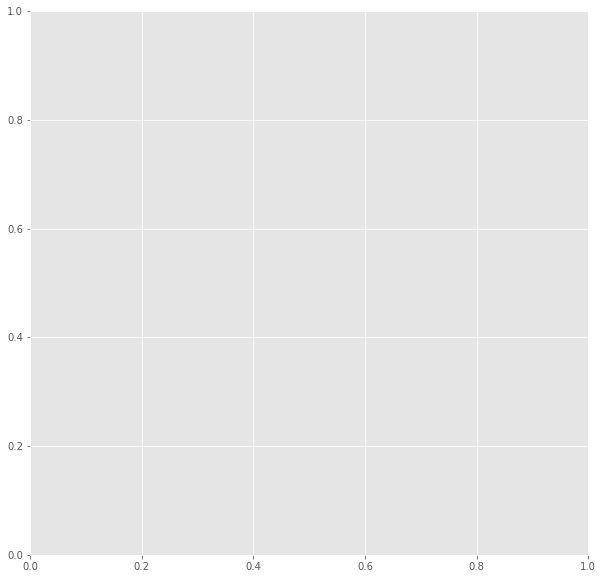

In [39]:
f1_scores = plot_f1s(valY, pred_Y)

In [ ]:
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

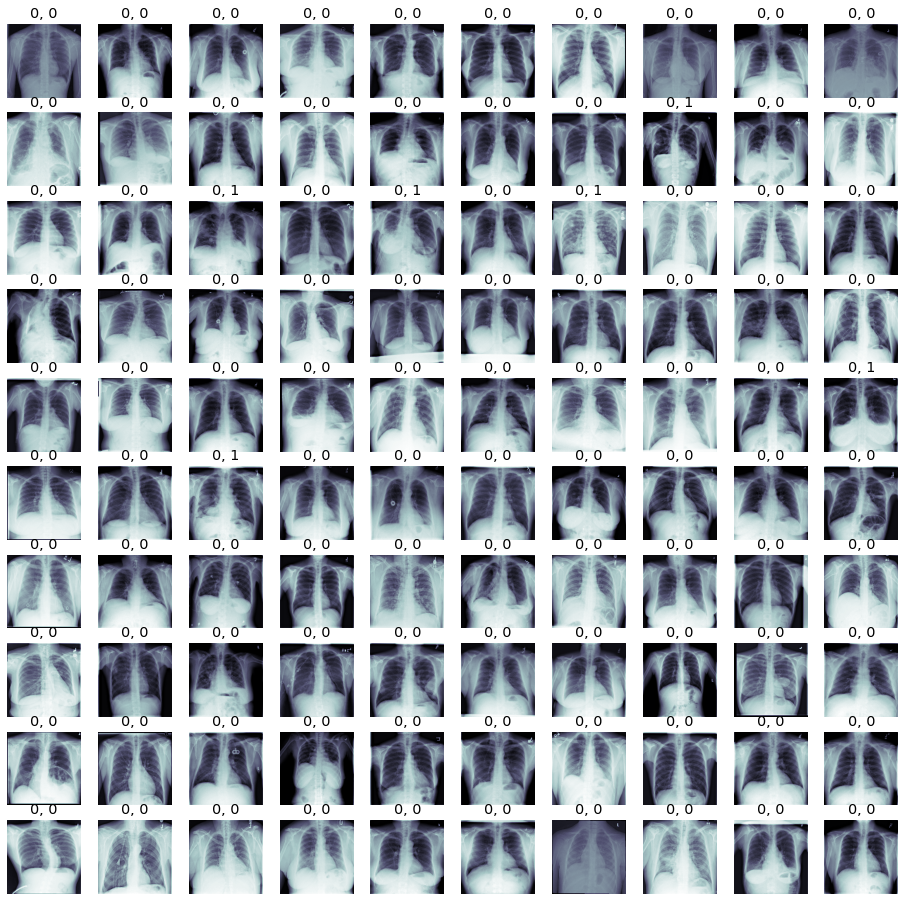

In [38]:
## Let's look at some examples of true vs. predicted with our best model: 

YOUR_THRESHOLD = 0.75
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], pred_Y[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
vgg_model.summary()

In [ ]:
my_model.summary()

In [39]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)